In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import re
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import random

In [3]:
# Read the dataset
with open("interviewku-chatbot-v2.json") as file:
  dataset = json.load(file)
with open("validasi.json") as file:
  val_dataset = json.load(file)

In [4]:
# Declare preprocessing text and dataset function
replace_words = [
    ['online', ['daring', 'remote']],
    ['meeting', ['gmeet', 'zoom']],
    ['persiapan',['persiapkan', 'disiapkan','dipersiapkan']],
    ['cv', ['curiculum vitae', 'resume']],
    ['penutup', ['closing statement']],
    ['mereschedule', ['jadwal ulang', 'menjadwalkan ulang', 'mengubah jadwal', 'merubah jadwal', 'pindah jadwal']],
    ['pewawancara', ['hrd']],
    ['bagus', ['menarik', 'keren', 'tepat']],
    ['kesalahan umum', ['kesalahan kecil']],
    ['saran', ['tips']],
    ['pakaian', ['baju', 'setelan', 'kostum']]
]

def preprocessing_text(sentence):
    filtered_words = re.sub(r'[^\w\d\s]', '', sentence.lower())
    words = word_tokenize(filtered_words)

    cleaned_words = []
    for word in words:
        replaced = False
        for replacement, target in replace_words:
            if word in target:
                cleaned_words.append(replacement)
                replaced = True
        if not replaced:
            cleaned_words.append(word)

    return ' '.join(cleaned_words)

def processing_json_dataset(dataset):
    tags = []
    inputs = []
    responses={}
    for intent in dataset:
        responses[intent['tag']]=intent['responses']
        for lines in intent['patterns']:
            inputs.append(preprocessing_text(lines))
            tags.append(intent['tag'])
    return [tags, inputs, responses]

def processing_json_val_dataset(dataset):
    tags = []
    inputs = []
    for intent in dataset:
        for lines in intent['patterns']:
            inputs.append(preprocessing_text(lines))
            tags.append(intent['tag'])
    return [tags, inputs]

In [5]:
# Split dataset
[tags, inputs, responses] = processing_json_dataset(dataset)
[val_tags, val_inputs] = processing_json_val_dataset(val_dataset)

In [6]:
# Import tokenizer from word dictionary
tokenizer_json_file = '../../word_dict/word_dictionary.json'
with open(tokenizer_json_file, 'r') as f:
    tokenizer_config = json.load(f)
tokenizer_array = tokenizer_config.keys()

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tokenizer_array)
word_index = tokenizer.word_index
print(len(word_index))

90014


In [7]:
# Grouping dataset
groupedData = []
for i in range(len(tags)):
    groupedData.append([tags[i], inputs[i], responses[tags[i]]])

val_groupedData = []
for i in range(len(val_tags)):
    val_groupedData.append([val_tags[i], val_inputs[i]])

In [8]:
# Shuffle dataset for better training
random.shuffle(groupedData)
random.shuffle(val_groupedData)

In [9]:
# Resplitting the dataset
train_label = [item[0] for item in groupedData]
train_input = [item[1] for item in groupedData]
shuffled_responses = [item[2] for item in groupedData]
val_label = [item[0] for item in val_groupedData]
val_input = [item[1] for item in val_groupedData]

In [10]:
# Converting the data into sequences and give a padding
trunc_type = 'post'
padding_type = 'post'
max_length = 14

tokenizer.fit_on_texts(train_input)
tokenizer.fit_on_texts(val_input)
training_sequences = tokenizer.texts_to_sequences(train_input)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(val_input)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

le = LabelEncoder()
training_labels = le.fit_transform(train_label)
validation_labels = le.fit_transform(val_label)

In [11]:
# Saving tokenizer dictionary data into json
word_dict = {item[0]: item[1] for item in tokenizer.word_index.items()}
with open('tokenizer_dict_chatbot.json', 'w') as json_file:
    json.dump(word_dict, json_file, indent=4)

In [12]:
# Saving dataset labels into json
leDecoder = LabelEncoder()
leDecoder.fit(train_label)
le_name_mapping = dict(zip(leDecoder.classes_, leDecoder.transform(leDecoder.classes_)))
transformed_classes = leDecoder.transform(leDecoder.classes_).tolist()
le_name_mapping = dict(zip(leDecoder.classes_, transformed_classes))
with open('chatbot_result_decoder.json', 'w') as json_file:
    json.dump(le_name_mapping, json_file, indent=4)

In [13]:
print(len(training_padded[0]))
print(training_padded.shape)
print(len(validation_padded[0]))
print(validation_padded.shape)

14
(55, 14)
14
(27, 14)


In [14]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  90020
output length:  25


In [15]:
# GloVe embedding
glove_dir = "../../glove.6B/glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir, encoding="utf8")
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
# Declare graph function and callback class
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.ylim(bottom=0)
    plt.show()
    
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # if logs.get('loss') < 0.3 and logs.get('val_accuracy') > 0.8:
        if logs.get('val_accuracy') > 0.8:
            self.model.stop_training = True

In [18]:
# Declare the model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(training_padded.shape[1])),
    tf.keras.layers.Embedding(input_dim=vocabulary+1, output_dim=100, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(
        filters=32,
        kernel_size=5,
        activation="relu",
    ),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, dropout=0.3, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, dropout=0.3)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(output_length, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 100)           9002100   
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            16032     
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 80)           23360     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               16160     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               5

In [19]:
# Compile and training the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(training_padded, training_labels, epochs=1000, batch_size=64, validation_data=(validation_padded, validation_labels), callbacks=[Callback()])

Epoch 1/1000
1/1 [==============================] - 18s 18s/step - loss: 3.2190 - accuracy: 0.0182 - val_loss: 3.2166 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 63ms/step - loss: 3.2177 - accuracy: 0.0545 - val_loss: 3.2146 - val_accuracy: 0.1481
Epoch 3/1000
1/1 [==============================] - 0s 66ms/step - loss: 3.2121 - accuracy: 0.0727 - val_loss: 3.2126 - val_accuracy: 0.1852
Epoch 4/1000
1/1 [==============================] - 0s 61ms/step - loss: 3.2105 - accuracy: 0.0909 - val_loss: 3.2105 - val_accuracy: 0.1852
Epoch 5/1000
1/1 [==============================] - 0s 61ms/step - loss: 3.1983 - accuracy: 0.0909 - val_loss: 3.2084 - val_accuracy: 0.2222
Epoch 6/1000
1/1 [==============================] - 0s 66ms/step - loss: 3.2014 - accuracy: 0.0909 - val_loss: 3.2062 - val_accuracy: 0.2593
Epoch 7/1000
1/1 [==============================] - 0s 58ms/step - loss: 3.2000 - accuracy: 0.1818 - val_loss: 3.2037 - val_accuracy: 0.2593
Epoch 8/1

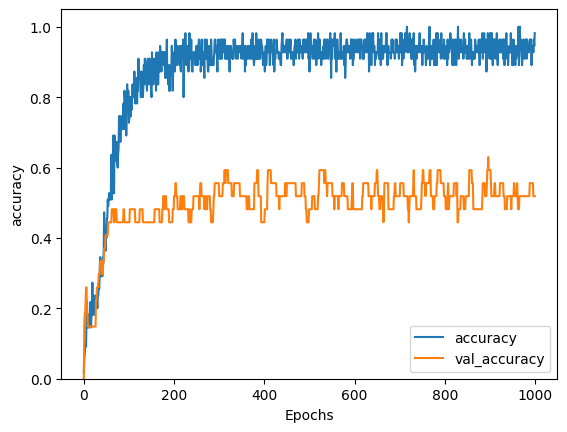

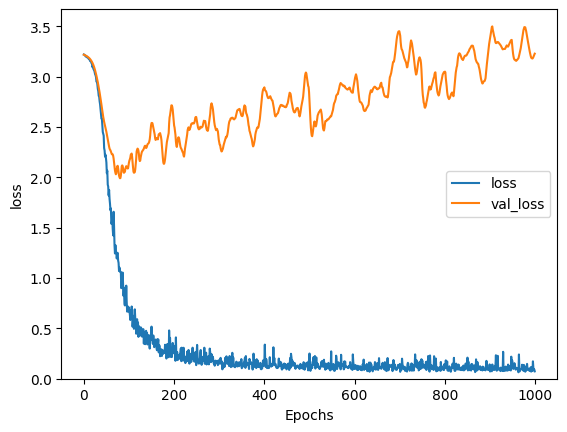

In [20]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")